# CAB420, Neural Attention, Bonus Example: Attention with DCNNs
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

## Overview

Attention is a network component that has become very common in many state of the art deep neural networks. We already saw

The idea of attention is to learn which parts of the input (or of some internal representation) are most relevant, and to try to direct the network towards these parts. There are very many different variations on attention, but the general approach can be summarised as:
* Learn an additional layer that will consider the importance of locations within an input
* Use this learned importance to weight the input/representation such that more important regions are more prominent

We'll look at a few variations on this these within the context of images in this example.

### Variation in Results

**Note that within the runs in this example, you'll see a fair bit of variation. Don't be shocked if you re-run things and suddenly one method goes up or down by 5%. The nature of these simple networks and small training set is that we do see some variation. Changes to the optimiser and to a larger batch size are aimed at helping curb this somewhat.**

### Runtimes

**This example is long. It contains one quite large network too (at the end), so if run in one hit it does take a while.**

### Where does this fit into all the other CAB420 content?

**This is another one of those examples that's really is getting well outside the scope of CAB420**.

If you're still here, this combines some of the ideas around auto-encoders and transformers into a powerful self-supervised learning framework. 

In [1]:
import os
import datetime
import numpy

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import layers

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat

from tensorflow.keras.utils import model_to_dot, plot_model

## Data

We'll use CIFAR here. CIFAR contains 32x32x3 images (i.e. colour) of the following ten things:

These images are richer and more varied than our usual suspects like fashion-MNIST, so we'll use them here. To keep things moving fast, we'll just use 60% of the data, though you can easily increase the amount being used if you wish.

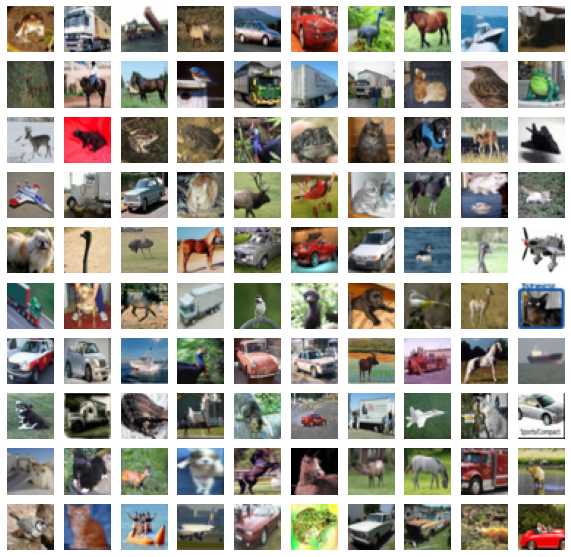

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

train_samples = 30000;
test_samples = 6000;
x_train = x_train[0:train_samples, :, :, :]
y_train = y_train[0:train_samples]
x_test = x_test[0:test_samples, :, :, :]
y_test = y_test[0:test_samples]

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_train[i,:,:,:])
    ax.axis('off')

## The Network

We'll keep it simple. We'll use a very simple CNN with three conv2D layers, with 8, 16 and 32 filters. We'll put max-pooling operations in between, and have one dense layer with 64 neurons before we hit classification. Other than that, it's pretty straight forward.

Before we get into attention, we'll train a vanilla version (our **baseline model**) to give us something to compare to.

In [3]:
# some training parameters the first two are fairly simple, change as you see fit
batch_size = 512
# Note, a couple of other networks down below that need more training time will scale this.
max_epochs = 50
# these for AdamW - adam with weight decay, which I'm using as it's a bit more stable
learning_rate = 0.01
weight_decay = 0.001

# we're going to train until the model stops improving. As such, we need to provide a 
# time-out value. We'll set it to 15 epochs, so if the model hasn't improved after 10
# epochs we'll stop training
patience = 15
# to determine when to stop, we need to monitor something. We have two decent options:
# the validation accuracy, or the validation loss.
monitor='val_accuracy' #'val_loss'

In [4]:
# 32x32x3 input as we have colour data
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
# 2D convolutional layers, 8 filters, 3x3 size kernels
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
# 2x2 max pooling
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# 2D convolution, 16 filters, 3x3 kernels
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
# 2x2 max pooling
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# final convolution, 32 filters, 3x3 kernel
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
# flatten representation
x = layers.Flatten()(x)
# a single fully connected layer, 64 inputs
x = layers.Dense(64, activation='relu')(x)
# and now our output
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print the summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='baseline_model')
model_cnn.summary()

Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
flatten (Flatten)            (None, 2048)           

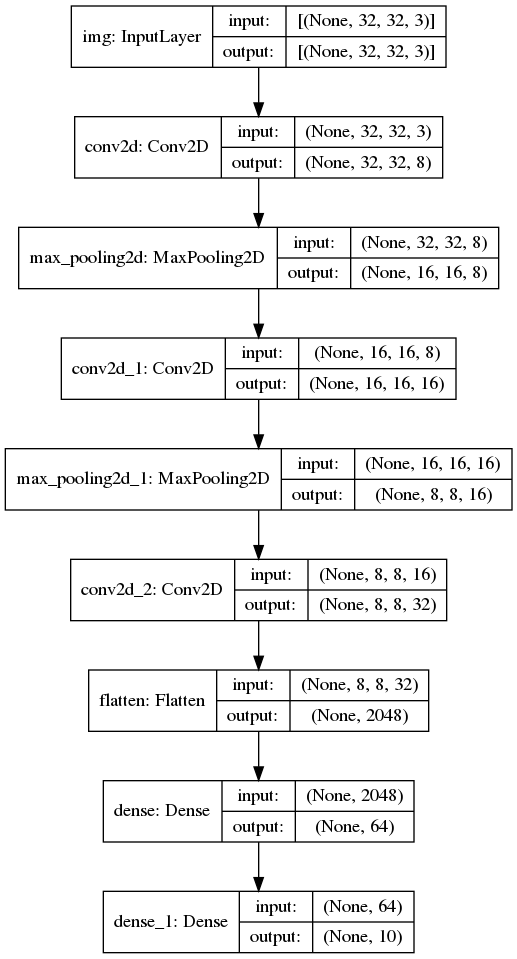

In [5]:
plot_model(model_cnn, show_shapes=True)

In [6]:
def fit_model(model_cnn, batch_size = batch_size, epochs = max_epochs):
    optimizer = tfa.optimizers.AdamW(
            learning_rate=learning_rate, weight_decay=weight_decay)
    model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      optimizer=optimizer,
                      metrics=['accuracy'], jit_compile=False)
    history = model_cnn.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=max_epochs,
                            validation_split=0.2,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience)],
                            verbose=False)
    return history, model_cnn

history, model_cnn = fit_model(model_cnn)

938/938 - 2s - loss: 1.1339 - accuracy: 0.6050
188/188 - 0s - loss: 1.6450 - accuracy: 0.4673


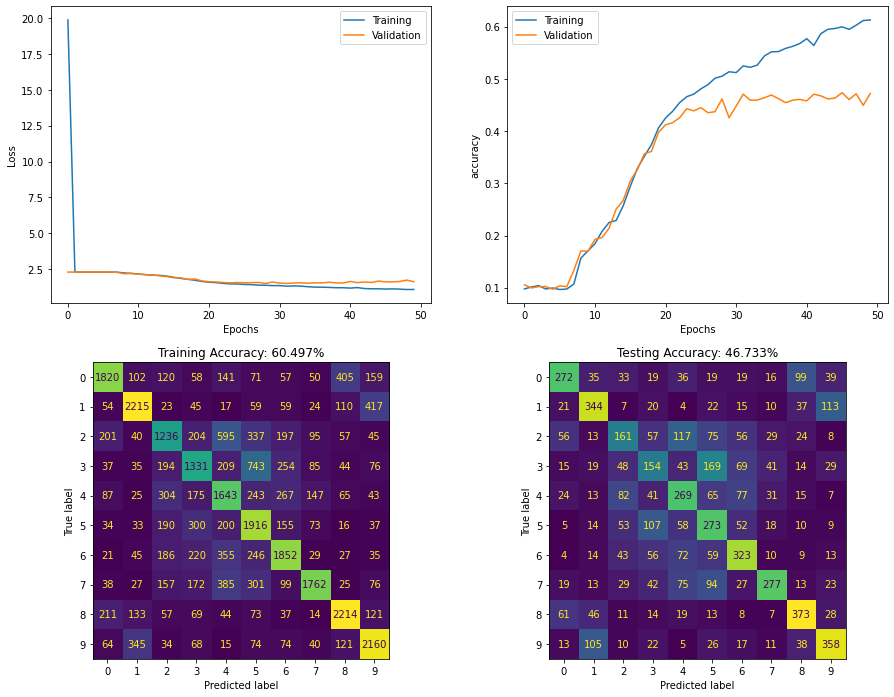

In [7]:
def eval_model(model, history, x_train, y_train, x_test, y_test):
    fig = plt.figure(figsize=[15, 12])

    ax = fig.add_subplot(2, 2, 1)
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['Training', 'Validation'])
    
    ax = fig.add_subplot(2, 2, 2)
    ax.plot(history.history['accuracy'])
    ax.plot(history.history['val_accuracy'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('accuracy')
    ax.legend(['Training', 'Validation'])

    test_scores = model.evaluate(x_train, y_train, verbose=2)
    pred = model.predict(x_train);
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    
    cm = confusion_matrix(y_train, indexes)
    ax = fig.add_subplot(2, 2, 3)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax, colorbar=None)
    ax.set_title('Training Accuracy: %2.3f%%' % (test_scores[1]*100))

    
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    
    cm = confusion_matrix(y_test, indexes)
    ax = fig.add_subplot(2, 2, 4)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax, colorbar=None)
    ax.set_title('Testing Accuracy: %2.3f%%' % (test_scores[1]*100))

eval_model(model_cnn, history, x_train, y_train, x_test, y_test)

Our baseline model is not amazing - and that's not a surprise. We have a very small network and we're not even using all the data. As such, we're seeing a bit of overfitting going on. Performance is on the whole not amazing, but is not catastrophic either.

## Attention

Let's add attention now. We can do this a few ways in terms of both the operation we use, and where we place our attention. 

### Attempt 1: Attention after second convolution, using a softmax activation

The sub-title says it all really. 

Our attention is really simple. What we are wanting to do is emphasise things that our network thinks are interesting. To do this we will:
* Train an extra layer that will output a weight as to how interesting/useful something is, based on an intermediate feature
* Multiply the intermediate feature in question by this weight, thus emphasising the features that the network thinks are useful

As we're adding a new layer, that layer needs an activation. There are two main approaches here:
* Using a softmax, which will tend to direct attention to a small number of (or even just one) important regions
* Using a sigmoid, which will allow the network to consider more features and flag more features as being important

We'll start with the softmax version. The following network takes our very simple network from above, and adds this simple attention mechanism.

In [8]:
# get softmax activations across a set of axes, i.e. the x and y axes of an image
def softMaxAxis(axis):
    def soft(x):
        return keras.activations.softmax(x,axis=axis)
    return soft

inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)

# This is the attention here
# First, we take our current representation and get a single channel representation of it, this
# will allow us to determine how important each location is
e = layers.Conv2D(1, 1, activation=None, name='pre_attention')(x)
# to get the importance, we can use a softmax. Note that we apply this over the width and height
a = layers.Activation(activation=softMaxAxis([1,2]), name='attention')(e)
# finally, we multiply our previous feature representation by our attention values. This way, we
# will supress things that we don't think are very important
x = layers.Multiply()([x, a])
# at this point, we just continue on, using our attention weighted features as the input to the 
# rest of the network

x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='attention_v1')
model_cnn.summary()

Model: "attention_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 8)    224         img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 8)    0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 16)   1168        max_pooling2d_2[0][0]            
_______________________________________________________________________________________

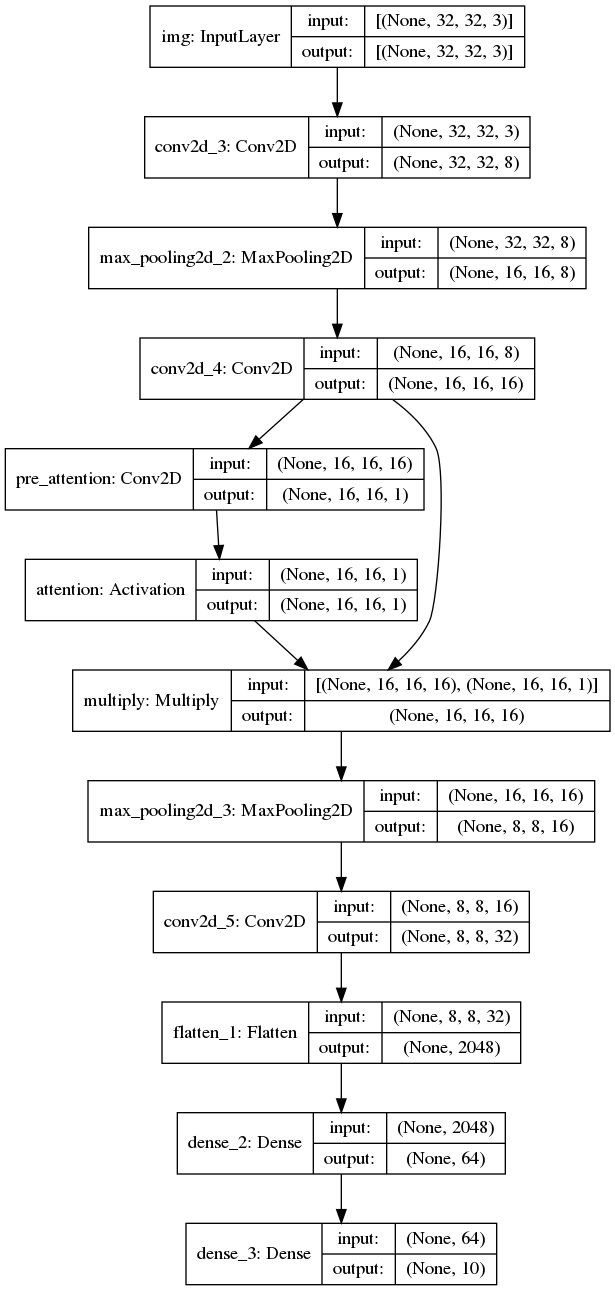

In [9]:
plot_model(model_cnn, show_shapes=True)

Looking at the above, we can see that this really doesn't add a lot to our network in terms of parameters. We add one new layer with parameters, our $1\times 1$ 2D convolution, and it has all of 17 parameters.

At this point, we can train and evaluate our model as per usual.

In [10]:
history, model_cnn = fit_model(model_cnn)

938/938 - 2s - loss: 1.0610 - accuracy: 0.6224
188/188 - 0s - loss: 1.2698 - accuracy: 0.5540


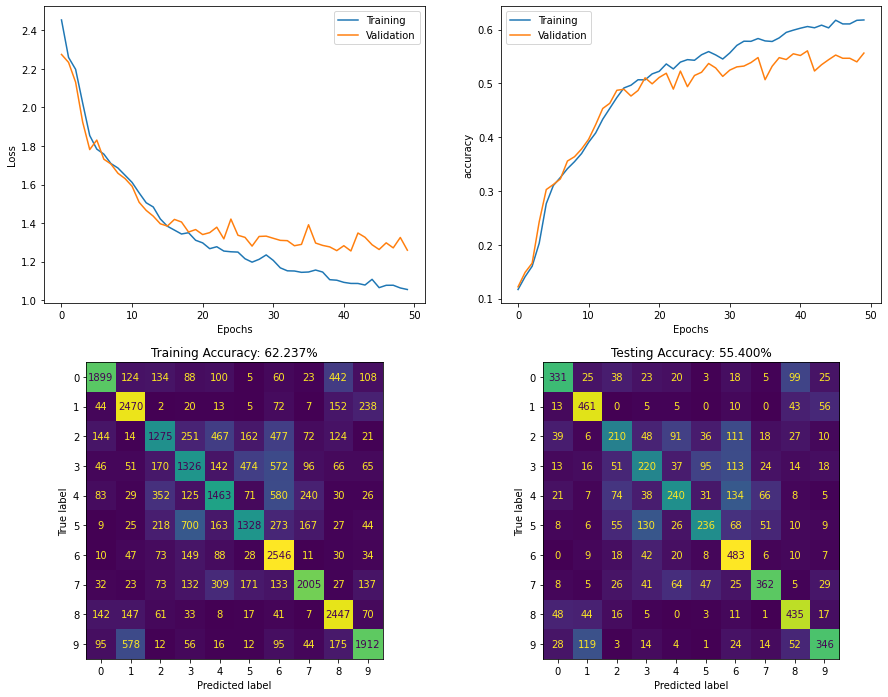

In [11]:
eval_model(model_cnn, history, x_train, y_train, x_test, y_test)

Interestingly, we've immediately gained a bunch of performance here, increasing ~10% in performance on the testing set.

This is quite a big gain for a small change in the network, and it's simply a result of helping the network to focus on what's important in the input image.

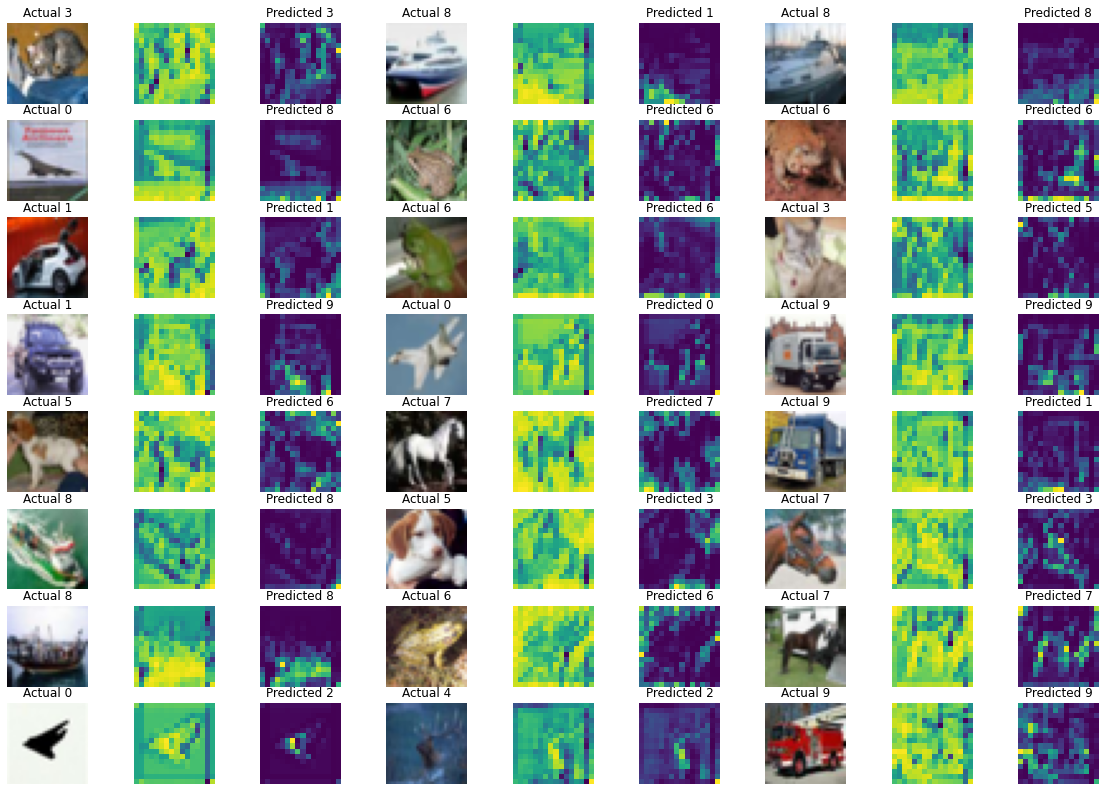

In [12]:
intermediate_layer_model = keras.Model(inputs=model_cnn.input,
                                       outputs=model_cnn.get_layer('pre_attention').output)
intermediate_layer_model_2 = keras.Model(inputs=model_cnn.input,
                                       outputs=model_cnn.get_layer('attention').output)

def plot_activations(model, intermediate_1, intermediate_2, x_test, y_test):

    predictions = model.predict(x_test[0:24,:,:,:])
    activations_1 = intermediate_1.predict(x_test[0:24,:,:,:])
    activations_2 = intermediate_2.predict(x_test[0:24,:,:,:])

    class_predictions = numpy.argmax(predictions, axis=1)

    fig = plt.figure(figsize=[20, 14])
    for i in range(24):
        ax = fig.add_subplot(8, 9, (i + 1)*3 - 2)
        ax.imshow(x_test[i,:,:,:])
        ax.axis('off')
        ax.set_title('Actual %d' % (y_test[i]))

        ax = fig.add_subplot(8, 9, (i + 1)*3 - 1)
        ax.imshow(activations_1[i,:,:,0])
    #    ax.imshow(activations[i,:,:,0], norm=matplotlib.colors.Normalize(0, 0.05))
        ax.axis('off')
        
        ax = fig.add_subplot(8, 9, (i + 1)*3)
        ax.imshow(activations_2[i,:,:,0])
    #    ax.imshow(activations[i,:,:,0], norm=matplotlib.colors.Normalize(0, 0.05))
        ax.axis('off')
        ax.set_title('Predicted %d' % (class_predictions[i]))        
        
plot_activations(model_cnn, intermediate_layer_model, intermediate_layer_model_2, x_test, y_test)

One nice thing about attention is that it's (usually) easier to visualise than other network components. We can visualise our attention maps. What we see here is where the model thinks we should focus on. For each sample, we have three images:
* The input image itself
* The output after the $1\times 1$ Convolution, which has no activation
* The output after the softmax

More yellow in the later two images indicates more attention (i.e. something the network thinks is more important). Some of these are more interpretible than others, and if you run this over and over again you'll get some different results on what the network focusses on. However, they are all broadly focussed on details of the objects and important edges. We frequently see attention being directed towards corners of objects, or the eyes of an animal's face for example.

Note that due to the way matplotlib displays these, you can't directly compare activation maps (the same colour does not mean the same attention across images). If you wish to look at this, you can use the commented out `imshow` line in the above to ensure normalisation is always into the same fixed scale.

#### Activations on the 1x1 Convolution layer

We can mix-up the activations we use in the attention block too. Below, we'll change our activation on the convolution layer that is actually pulling out our attention scores. Above, we have no activation on this and pass the raw data straight to our softmax.

Let's start by throwing a tanh on things, which will bound our values [-1, 1].

938/938 - 2s - loss: 0.6831 - accuracy: 0.7858
188/188 - 0s - loss: 1.5876 - accuracy: 0.5682


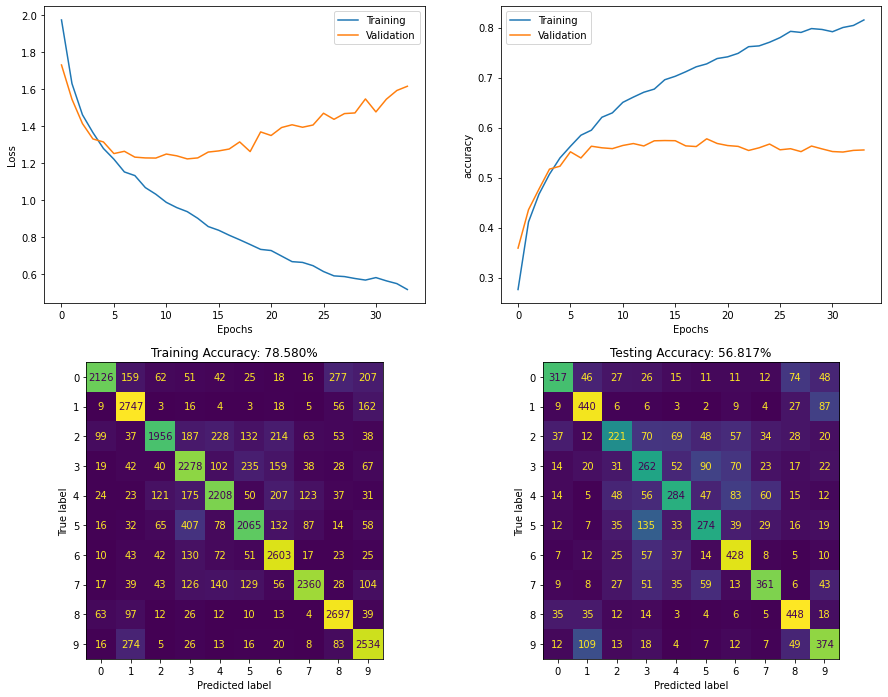

In [13]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)

# This is the attention here
# First, we take our current representation and get a single channel representation of it, this
# will allow us to determine how important each location is
e = layers.Conv2D(1, 1, activation='tanh', name='pre_attention')(x)
# to get the importance, we can use a softmax. Note that we apply this over the width and height
a = layers.Activation(activation=softMaxAxis([1,2]), name='attention')(e)
# finally, we multiply our previous feature representation by our attention values. This way, we
# will supress things that we don't think are very important
x = layers.Multiply()([x, a])
# at this point, we just continue on, using our attention weighted features as the input to the 
# rest of the network

x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='attention_v2')

history, model_cnn = fit_model(model_cnn)

eval_model(model_cnn, history, x_train, y_train, x_test, y_test)

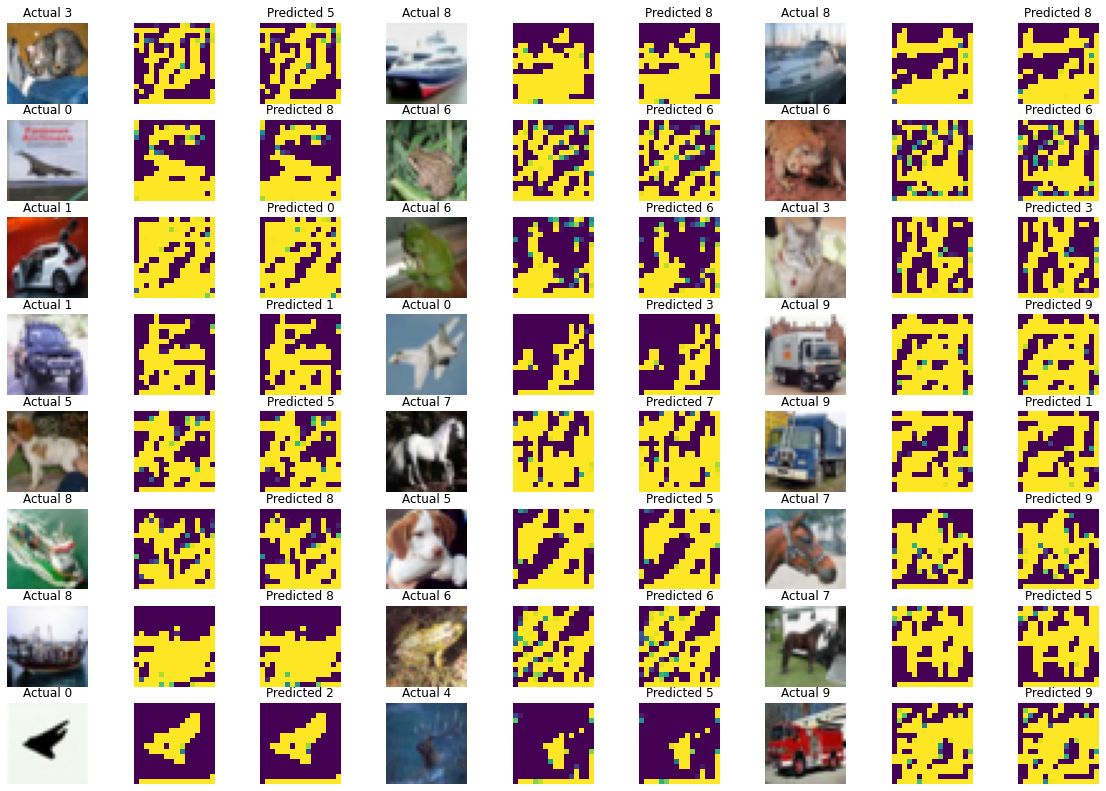

In [14]:
intermediate_layer_model = keras.Model(inputs=model_cnn.input,
                                       outputs=model_cnn.get_layer('pre_attention').output)
intermediate_layer_model_2 = keras.Model(inputs=model_cnn.input,
                                       outputs=model_cnn.get_layer('attention').output)

plot_activations(model_cnn, intermediate_layer_model, intermediate_layer_model_2, x_test, y_test)

We see this changes our attention maps quite a bit, and leaves out a lot of shades of grey that we had originally. Things are either in, or they're out.

#### Clipped ReLu

Let's now throw a clipped Relu at things. This functions like a regular Relu, but saturates at some maximum value. We'll set that $4.0$. The hope is to get somewhere between the no activtion option and the tanh option, i.e. be a bit more selective, but not too much.

938/938 - 2s - loss: 0.7357 - accuracy: 0.7565
188/188 - 0s - loss: 1.4614 - accuracy: 0.5753


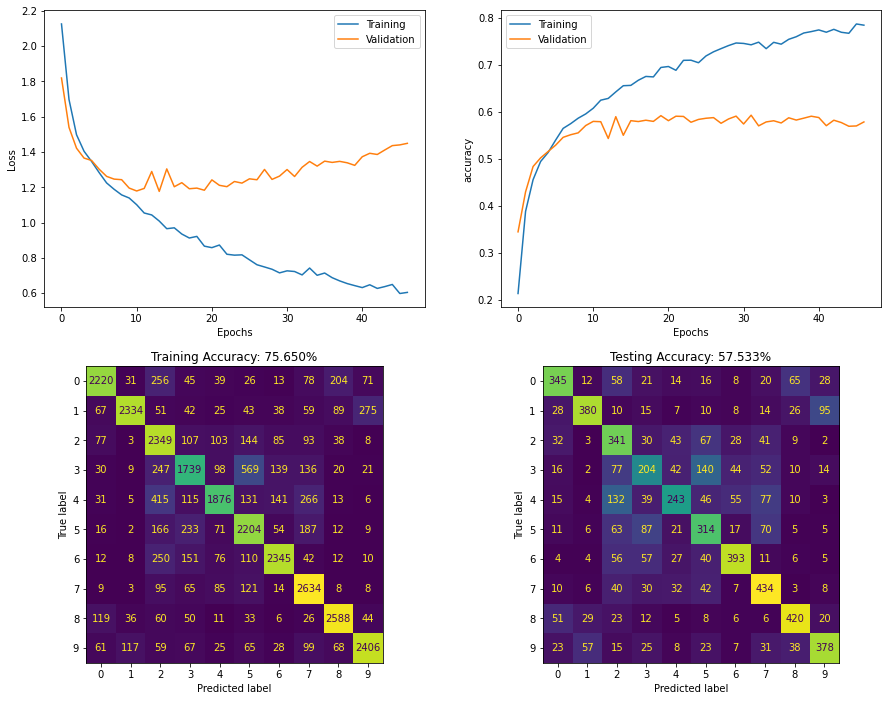

In [15]:
def clipped_relu(x, max_value = 20):
    def clipped(x):
        return keras.activations.relu(x, max_value = max_value)
    return clipped

inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)

# This is the attention here
# First, we take our current representation and get a single channel representation of it, this
# will allow us to determine how important each location is
e = layers.Conv2D(1, 1, activation=clipped_relu(4.0), name='pre_attention')(x)
# to get the importance, we can use a softmax. Note that we apply this over the width and height
a = layers.Activation(activation=softMaxAxis([1,2]), name='attention')(e)
# finally, we multiply our previous feature representation by our attention values. This way, we
# will supress things that we don't think are very important
x = layers.Multiply()([x, a])
# at this point, we just continue on, using our attention weighted features as the input to the 
# rest of the network

x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='attention_v3')

history, model_cnn = fit_model(model_cnn)

eval_model(model_cnn, history, x_train, y_train, x_test, y_test)

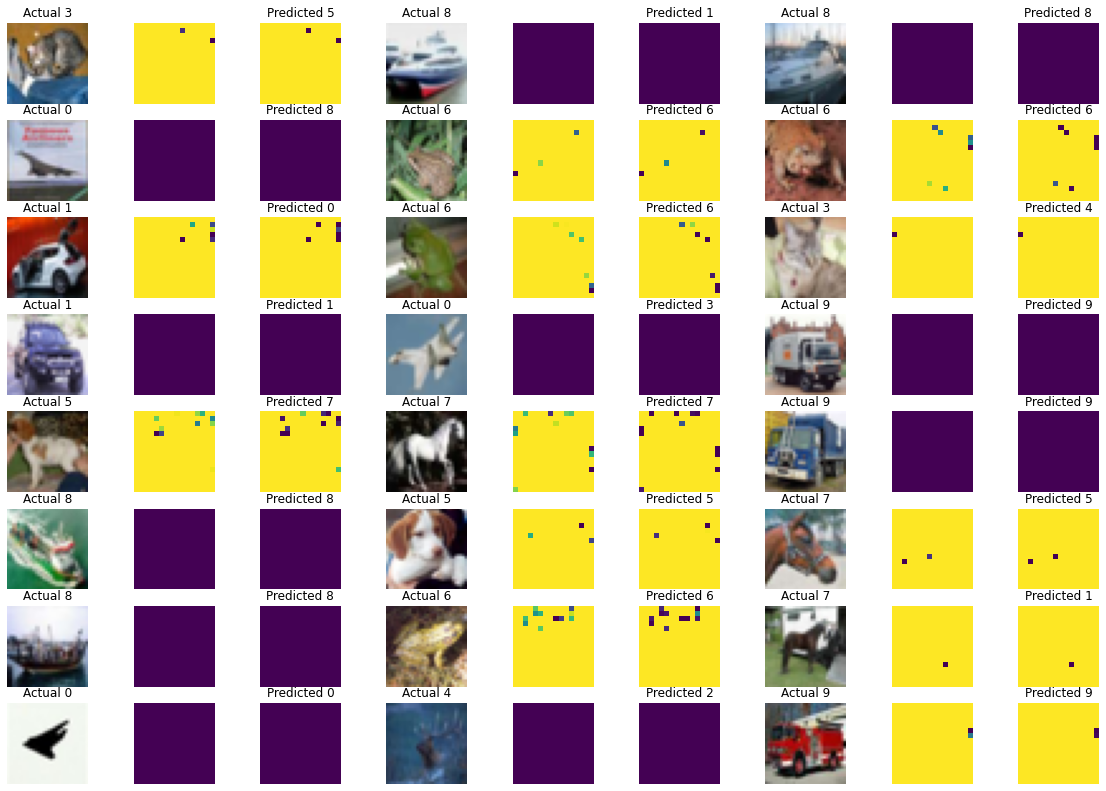

In [16]:
intermediate_layer_model = keras.Model(inputs=model_cnn.input,
                                       outputs=model_cnn.get_layer('pre_attention').output)
intermediate_layer_model_2 = keras.Model(inputs=model_cnn.input,
                                       outputs=model_cnn.get_layer('attention').output)

plot_activations(model_cnn, intermediate_layer_model, intermediate_layer_model_2, x_test, y_test)

Performance wise, we're at about the same point as our tanh, but we can see a bit more sublty in our attention maps - we're no longer just turning things on and off sometimes (though quite often we still are). We could further play with the clipping range to bring more variation into things if we so wished.

### Attempt 2: Attention after third convolution, using a softmax activation

As per the title, let's move the attention down the chain a bit. We'll keep the clipped relu as our activation after the 1x1 convolution.

In [17]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)

# our attention is exactly the same as it was last time, we've now just pushed it down one more 
# convolution layer, so now it's looking at higher level features.
e = layers.Conv2D(1, 1, activation=clipped_relu(4), name='pre_attention')(x)
a = layers.Activation(activation=softMaxAxis([1, 2]), name='attention')(e)
x = layers.Multiply()([x, a])

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='attention_v4')
model_cnn.summary()

Model: "attention_v4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 8)    224         img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 16, 16, 8)    0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 16, 16, 16)   1168        max_pooling2d_8[0][0]            
_______________________________________________________________________________________

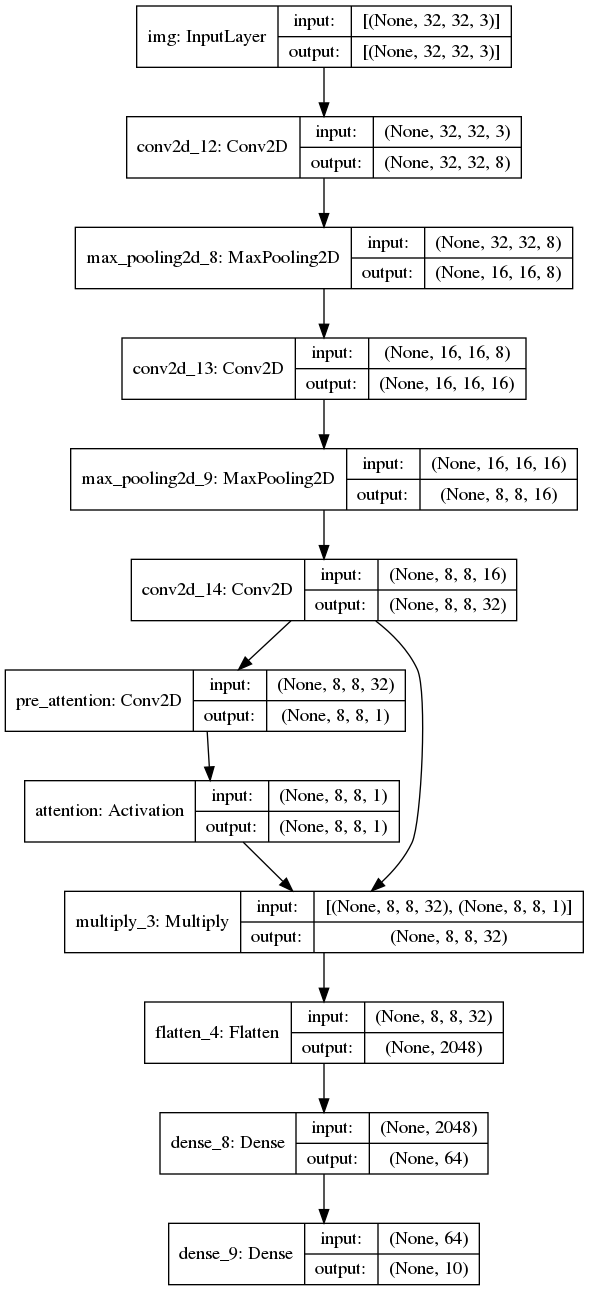

In [18]:
plot_model(model_cnn, show_shapes=True)

In [19]:
history, model_cnn = fit_model(model_cnn)

938/938 - 2s - loss: 0.7429 - accuracy: 0.7528
188/188 - 0s - loss: 1.2985 - accuracy: 0.5873


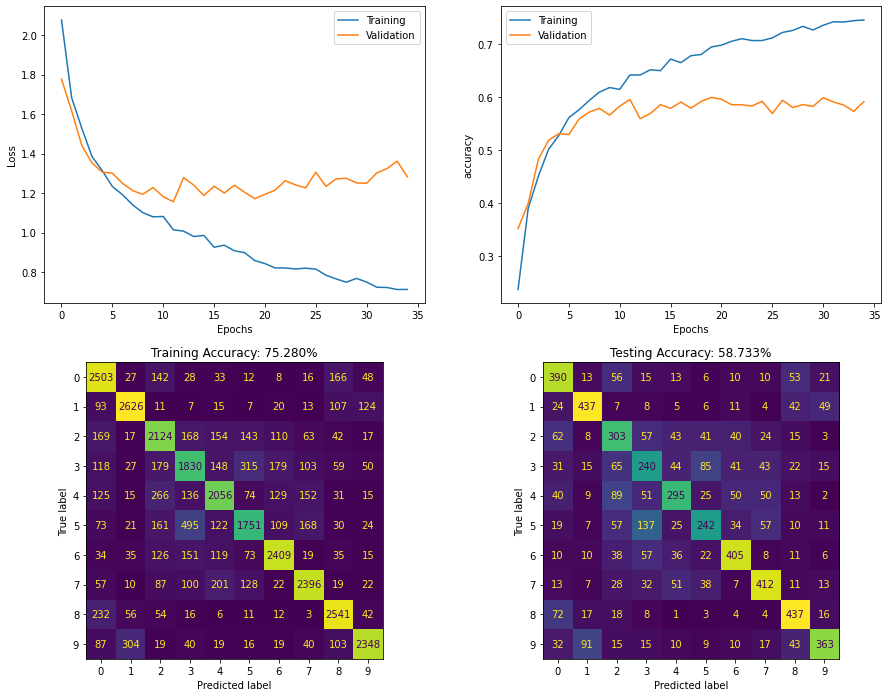

In [20]:
eval_model(model_cnn, history, x_train, y_train, x_test, y_test)

The accuracy you still here is, in my experience on average a bit lower than what we had in attempt 1 (it will vary from one run to the next), but it's still well above the baseline.

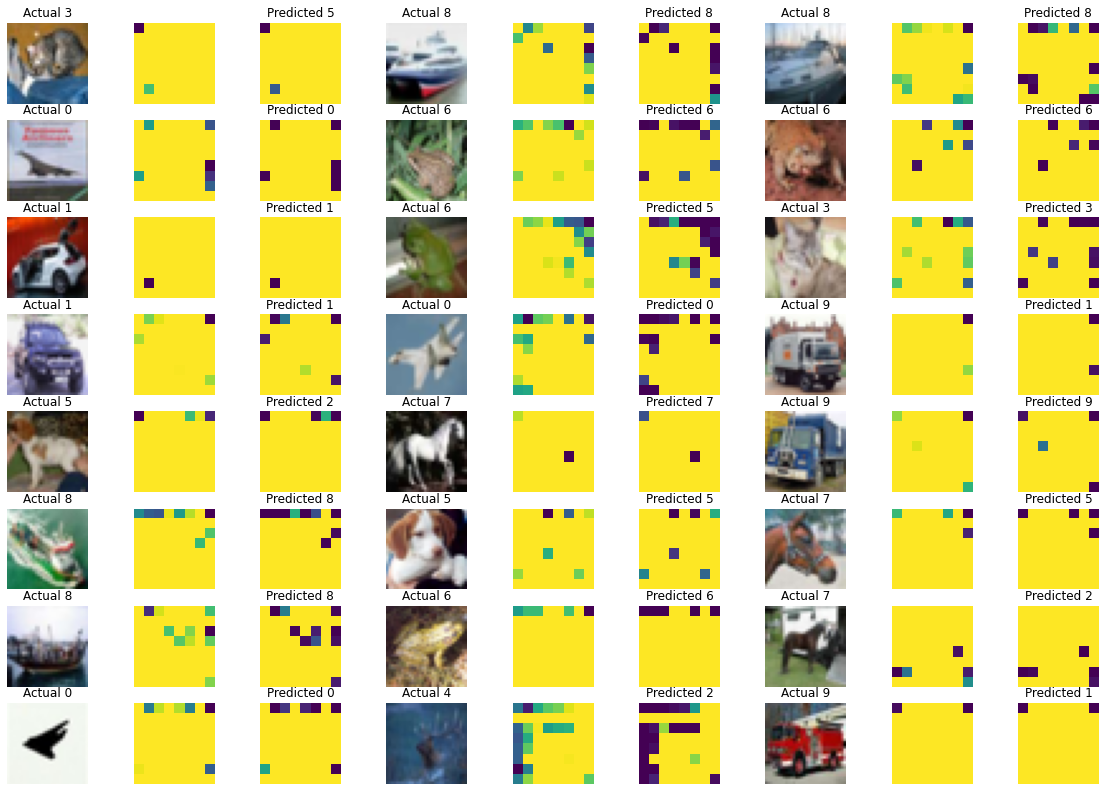

In [21]:
intermediate_layer_model = keras.Model(inputs=model_cnn.input,
                                       outputs=model_cnn.get_layer('pre_attention').output)
intermediate_layer_model_2 = keras.Model(inputs=model_cnn.input,
                                       outputs=model_cnn.get_layer('attention').output)

plot_activations(model_cnn, intermediate_layer_model, intermediate_layer_model_2, x_test, y_test)

The visualisations are perhaps a bit less understandable than the earlier ones. This is really due to the features coming from deeper in the network. Here, after two max-pools and three 3x3 convolutions, each pixel is is actually a result of a large chunk of the image, so patterns are less clear. 

### Attempt 3: Attention after first convolution, using a sigmoid activation

Let's change the activation now that exists on our actual attention layer. We'll go to a sigmoid, which will (mostly) act as a hard switch to turn data flow on or off.

Note that here, we have removed the first activation (on the 1x1 convolution layer). If we think about what we had here with (for example) the tanh:
* we used the tanh to force values into the range [-1..1], with most values at one of the extremes
* we then used a softmax to normalise these
This softmax has the biggest impact for those values that are away from the extremes (i.e. in the middle); and we see it actually has more of an impact with the clipped relu (which will outputs values from [0...max_value (which we set to 4)]) which has a larger middle. 

For our sigmoid activation, we have an activation that's trying to force values into the range [0..1] - essentially it's a scaled and shifted tanh - so having two of these one after the other doesn't make much sense.

In [22]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)

# our attention block. Very similar to before
e = layers.Conv2D(1, 1, activation=None, name='pre_attention')(x)
# but here, we use a sigmoid activation rather than a softmax
a = layers.Activation(activation='sigmoid', name='attention')(e)
x = layers.Multiply()([x, a])

x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='attention_v5')
model_cnn.summary()

Model: "attention_v5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 32, 8)    224         img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 16, 16, 8)    0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 16, 16, 16)   1168        max_pooling2d_10[0][0]           
_______________________________________________________________________________________

In [23]:
history, model_cnn = fit_model(model_cnn)

938/938 - 2s - loss: 1.0557 - accuracy: 0.6347
188/188 - 0s - loss: 1.6370 - accuracy: 0.4717


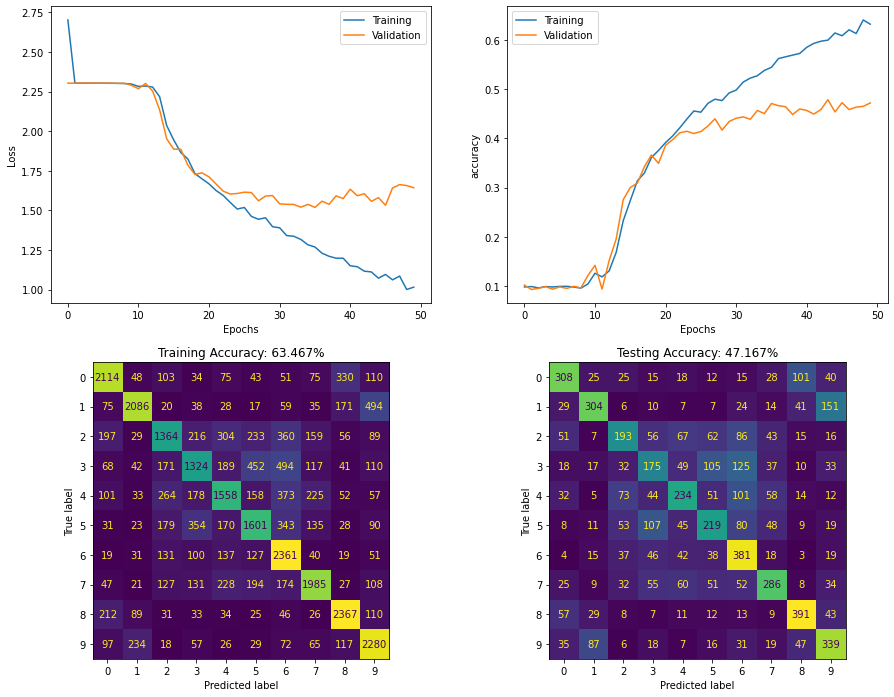

In [24]:
eval_model(model_cnn, history, x_train, y_train, x_test, y_test)

Performance wise, we've lot a lot, though we're still ahead of our baseline.

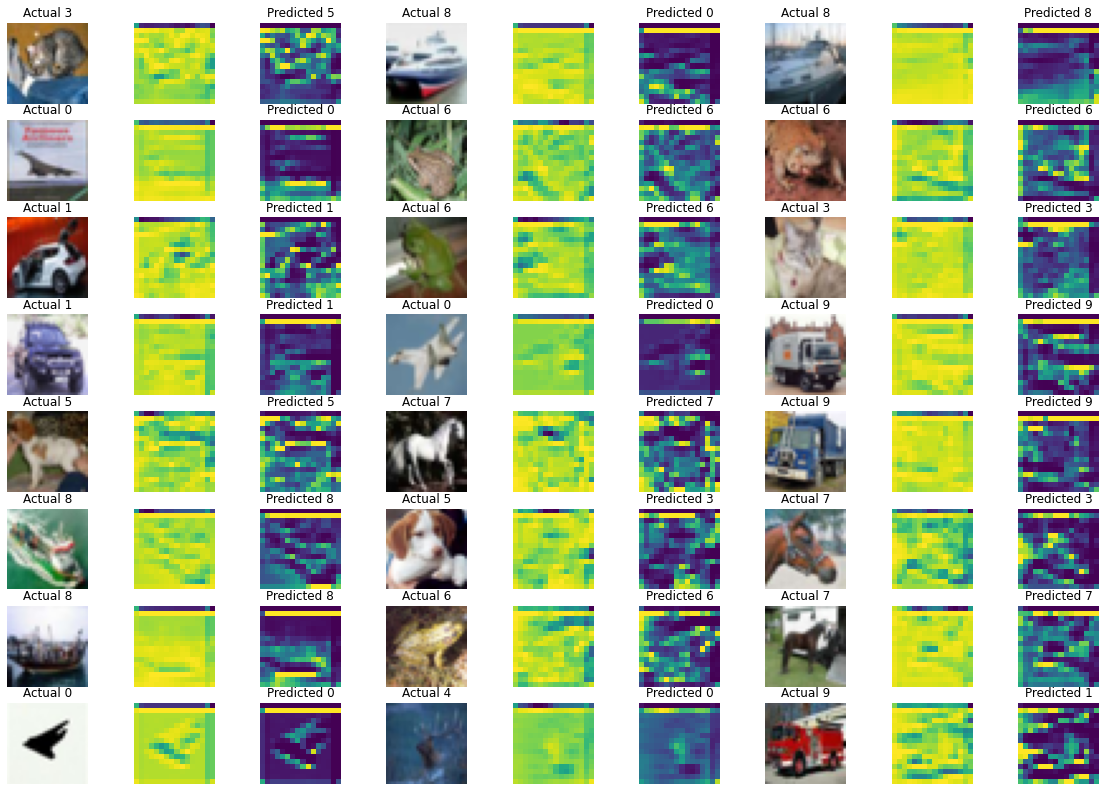

In [25]:
intermediate_layer_model = keras.Model(inputs=model_cnn.input,
                                       outputs=model_cnn.get_layer('pre_attention').output)
intermediate_layer_model_2 = keras.Model(inputs=model_cnn.input,
                                       outputs=model_cnn.get_layer('attention').output)

plot_activations(model_cnn, intermediate_layer_model, intermediate_layer_model_2, x_test, y_test)

Visualisation wise, we can see that this is being somewhat selective, with a wide variation in what's passed for each image, and even how much information is passed through for each image.

### Attempt 4: Attention after second convolution, using a sigmoid activation

By now, you should know the drill.

In [26]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)

e = layers.Conv2D(1, 1, activation=None, name='pre_attention')(x)
a = layers.Activation(activation='sigmoid', name='attention')(e)
x = layers.Multiply()([x, a])

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='attention_v6')
model_cnn.summary()

Model: "attention_v6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 8)    224         img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 16, 16, 8)    0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 16, 16, 16)   1168        max_pooling2d_12[0][0]           
_______________________________________________________________________________________

In [27]:
history, model_cnn = fit_model(model_cnn)

938/938 - 2s - loss: 2.3020 - accuracy: 0.1011
188/188 - 0s - loss: 2.3023 - accuracy: 0.0992


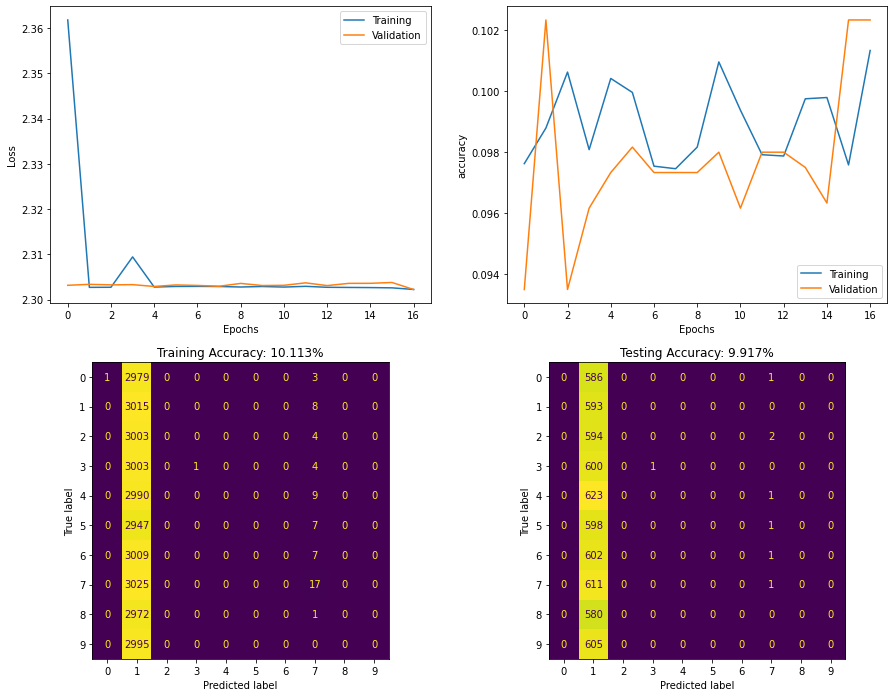

In [28]:
eval_model(model_cnn, history, x_train, y_train, x_test, y_test)

Again, we're ahead of the baseline, but behind most/all (depending on your training run) of our other systems.

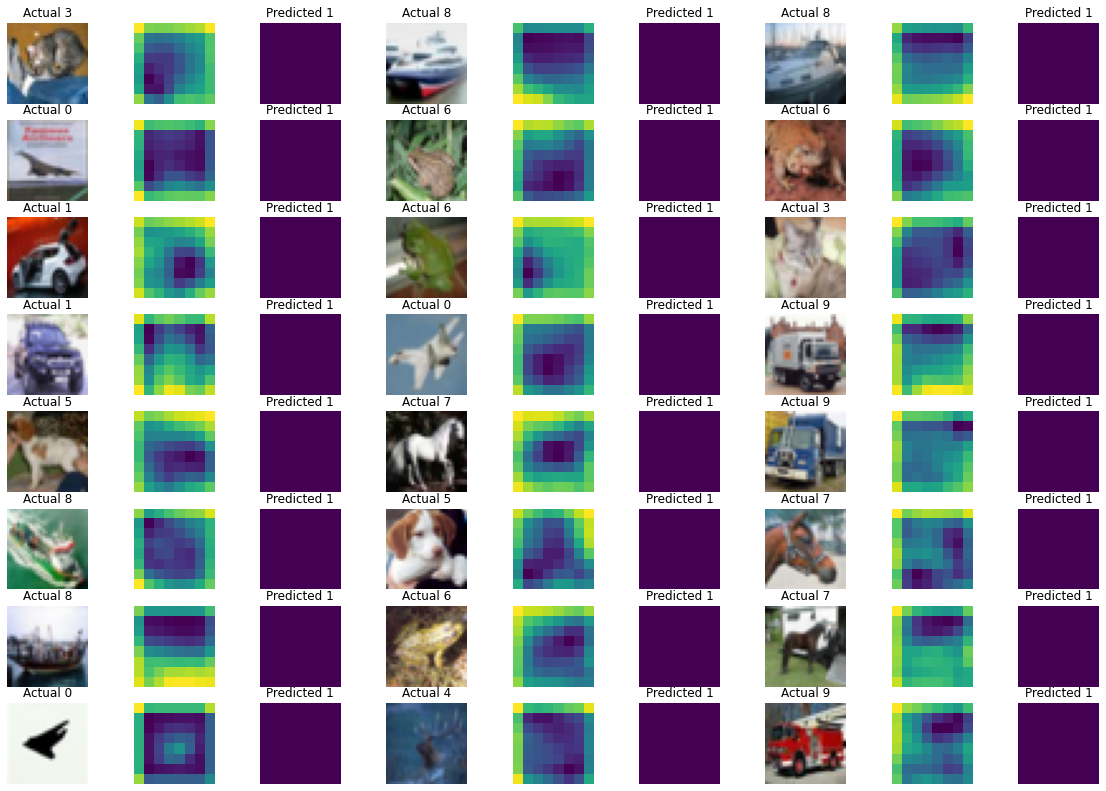

In [29]:
intermediate_layer_model = keras.Model(inputs=model_cnn.input,
                                       outputs=model_cnn.get_layer('pre_attention').output)
intermediate_layer_model_2 = keras.Model(inputs=model_cnn.input,
                                       outputs=model_cnn.get_layer('attention').output)

plot_activations(model_cnn, intermediate_layer_model, intermediate_layer_model_2, x_test, y_test)

Visualisation wise, we can see that we pick up a small number of relevant patches per image. This then helps direct the most important information into our final couple of fully connected layers.

### How much attention can I have?

Because we can, we'll throw in three lots:
* A soft-max attention after the first convolution layer
* A soft-max attention after the second convolution layer
* A sigmoid attention after the final convolution layer

Is there any real benefit to this? I would suggest it's marginal - really this is about just showing that it can be done.

In [30]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# first attention
e = layers.Conv2D(1, 1, activation=clipped_relu(4))(x)
a = layers.Activation(activation=softMaxAxis([1, 2]), name='attention_1')(e)
x = layers.Multiply()([x, a])

x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# second attention
e = layers.Conv2D(1, 1, activation=clipped_relu(4))(x)
a = layers.Activation(activation=softMaxAxis([1, 2]), name='attention_2')(e)
x = layers.Multiply()([x, a])

x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)

# third attention
e = layers.Conv2D(1, 1, activation=None)(x)
a = layers.Activation(activation='sigmoid', name='attention_3')(e)
x = layers.Multiply()([x, a])

x = layers.Flatten()(x)
x = layers.Dense(64, activation=None)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='all_the_attention')
model_cnn.summary()

Model: "all_the_attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 8)    224         img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_14 (MaxPooling2D) (None, 16, 16, 8)    0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 16, 16, 1)    9           max_pooling2d_14[0][0]           
__________________________________________________________________________________

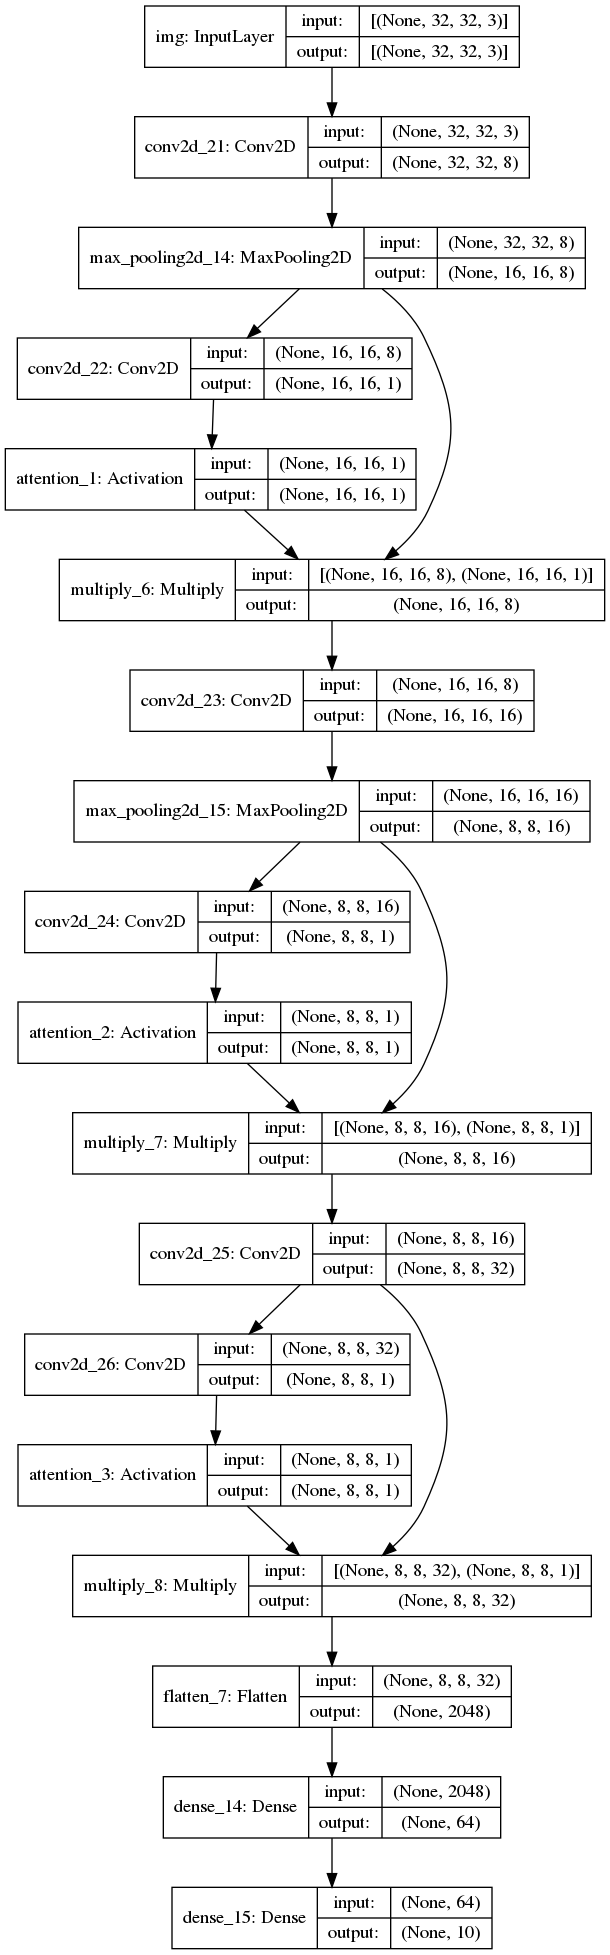

In [31]:
plot_model(model_cnn, show_shapes=True)

In [32]:
history, model_cnn = fit_model(model_cnn, epochs=max_epochs*2)

938/938 - 2s - loss: 1.1306 - accuracy: 0.6005
188/188 - 0s - loss: 1.2237 - accuracy: 0.5825


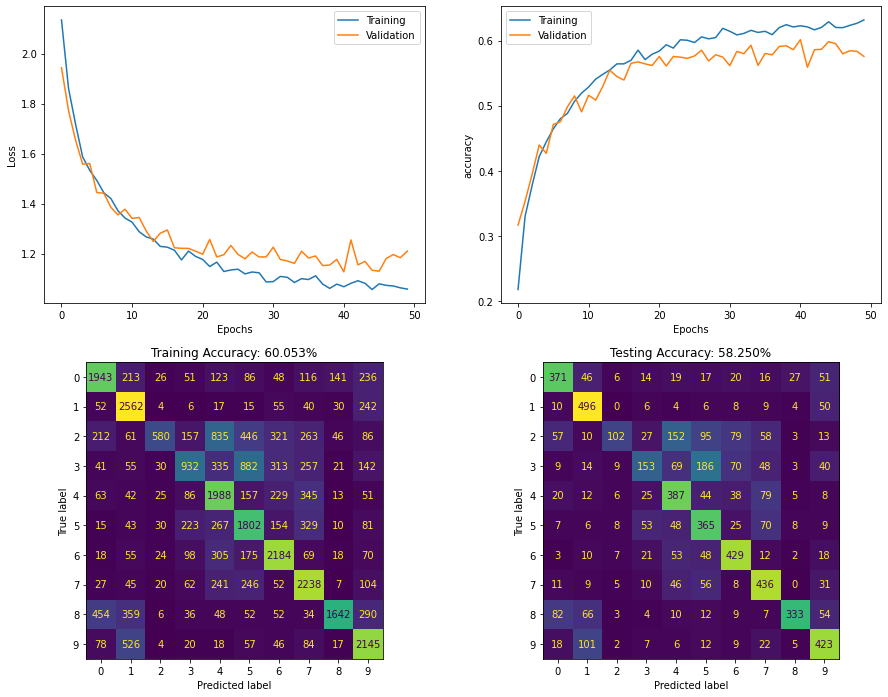

In [33]:
eval_model(model_cnn, history, x_train, y_train, x_test, y_test)

We haven't gained super-powers by overloading on attention, and are perhaps starting to strangle the network a little here. However, we're still above our baseline.

## Different Self-Attention Formulations

There's no set way to "do attention". If you start digging to the literature (or even just random deep learning blogs that discuss attention) you'll see more flavours of attention than there are ice cream. All of these are trying to do the same thing however: help the network identify important things.

We'll consider two different ways here, both of which will operate over the output of the second convolution layer like our first attempt above. Both can be moved, and manipulated further - but this example is getting long as it is - so we'll leave that to your own exploration.

In both these cases, we'll use dense layers to learn our attention values. This will give the network a bit more capacity to learn attention as our attention layers will have a few more parameters (though without any strong priors that convolution implies).

### Attempt 1: Something Sensible

We'll add an extra dense layer in here after our 1D conv. Consider our above approaches, these:
* Look at each pixel in isolatation, and we get a weight for that pixel considering only that pixel
* These weights are then normalised
So, each pixel's weight is based on that pixel alone, there is no understanding of the local neighbourhood.

Here, we'll do a more comprehensive thing and after we have our 1x1 convolution, we'll have a dense layer with the same input size as out output size. What we'll try to do is learn a weight for each pixel based on all the pixels, i.e. each of the 256 outputs (i.e. $16\times 16$ pixels) is a product of all 256 inputs.

In [34]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)

# This is the attention here
# First, we take our current representation and get a single channel representation of it
e = layers.Conv2D(1, 1, activation='relu', name='pre_attention')(x)
# now, we'll flatten that. We want to pass this through a dense layer to get attention for each location
e = layers.Flatten()(e)
# this is now effectivley our attention layer. We'll apply a softmax activation to it to emphasise
# important locations. We could also use a sigmoid here. I've also got L1 regularisation going here
# to try and focus on just finding the few most important things
e = layers.Dense(16*16, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1(0.01))(e)
# I still need to multiply my attention with the input, so I need to get the dense layer back into a
# square shape
a = layers.Reshape((16, 16, 1), name='attention')(e)
# finally, we multiply our previous feature representation by our attention values. This way, we
# will supress things that we don't think are very important
x = layers.Multiply()([x, a])
# at this point, we just continue on, using our attention weighted features as the input to the 
# rest of the network

x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='more_attention')
model_cnn.summary()

Model: "more_attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 32, 32, 8)    224         img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 16, 16, 8)    0           conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 16, 16, 16)   1168        max_pooling2d_16[0][0]           
_____________________________________________________________________________________

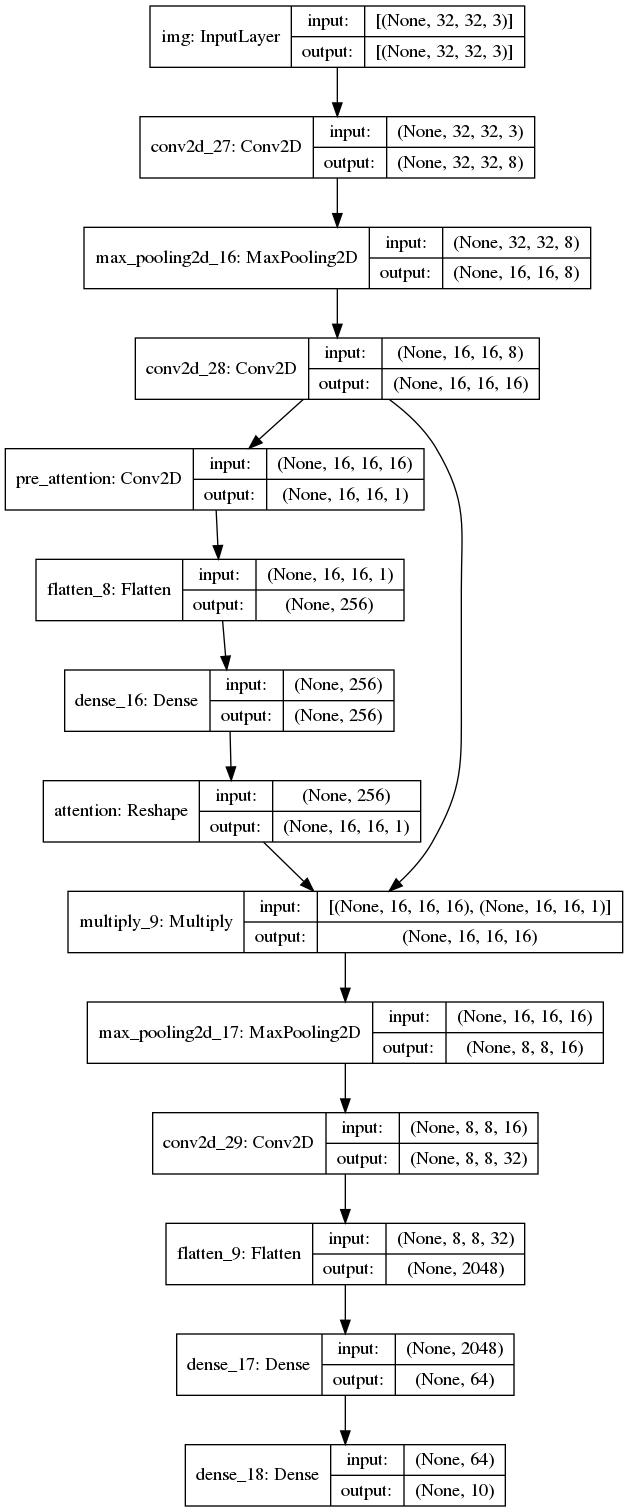

In [35]:
plot_model(model_cnn, show_shapes=True)

We can now train and evaluate our model as we have before.

In [36]:
history, model_cnn = fit_model(model_cnn)

938/938 - 2s - loss: 1.4955 - accuracy: 0.7235
188/188 - 0s - loss: 1.9879 - accuracy: 0.5773


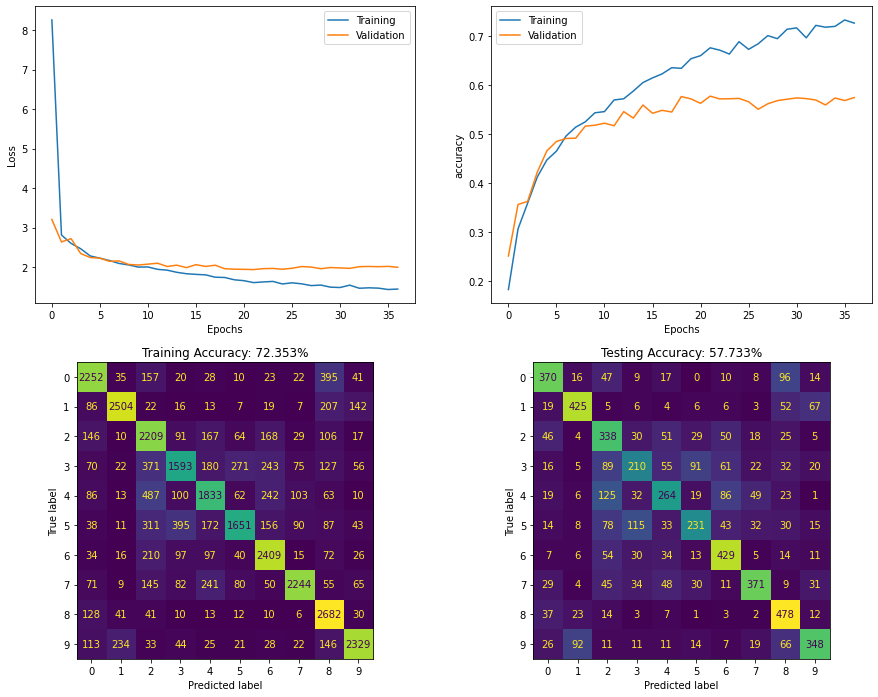

In [37]:
eval_model(model_cnn, history, x_train, y_train, x_test, y_test)

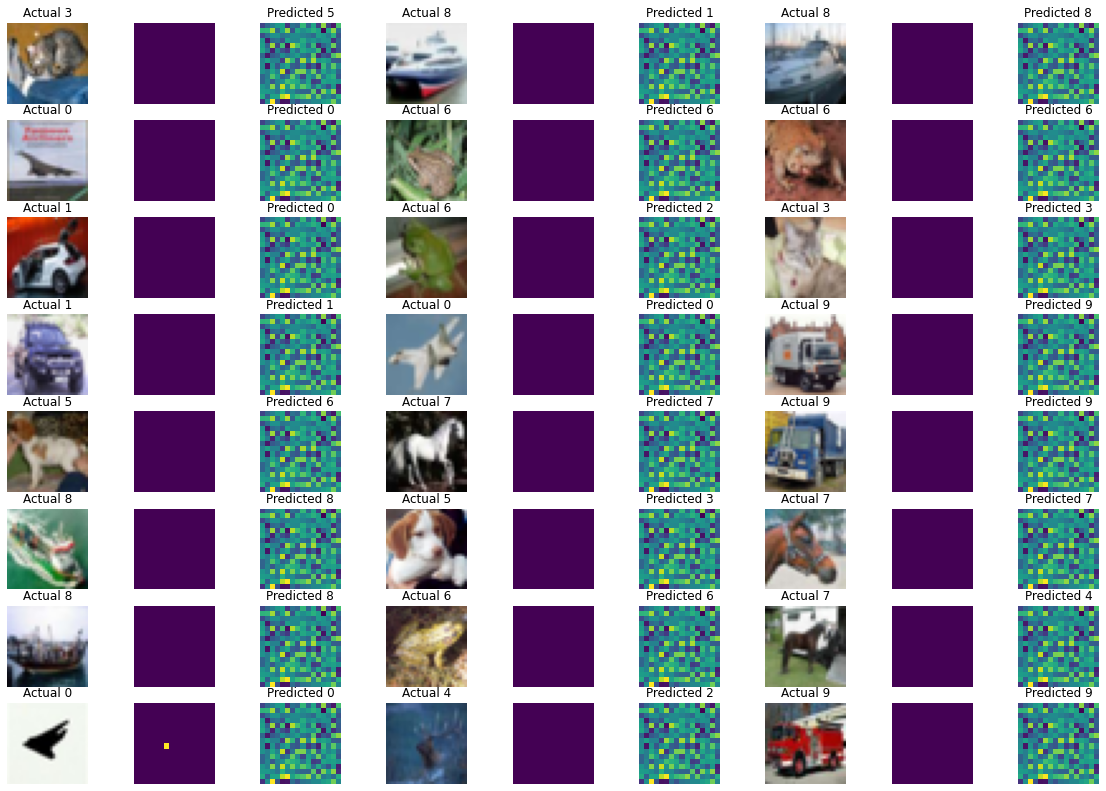

In [38]:
intermediate_layer_model = keras.Model(inputs=model_cnn.input,
                                       outputs=model_cnn.get_layer('pre_attention').output)
intermediate_layer_model_2 = keras.Model(inputs=model_cnn.input,
                                       outputs=model_cnn.get_layer('attention').output)

plot_activations(model_cnn, intermediate_layer_model, intermediate_layer_model_2, x_test, y_test)

We can see this works pretty well, and is an improvement on what we had earlier (for most training runs) - although there is a sameness to our activation maps. This is likely in part due to the dataset, which has things of interest located in the centre of the image fairly consistently, so the network can learn to look at a particular part (somewhere around the middle) and know that it's looking in the right spot.

### Attempt 2: Something Silly

In all the examples so far, we've considered attention at the pixel level, i.e. we've done some operation to go from a 16 channel representation down to a 1 channel representation and learnt our attention on that. For our last trick, let's not do that.

This is really very much like the above, except that our 1x1 convolution is now gone. This means that our attention input is now a $16\times 16\times 16$ tensor, and so we need to learn $16\times 16\times 16$ attention scores.

In [39]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)

# This is the attention here
# We're now going to learn attention directly over the 16 channel representation, so there's
# no more 1x1 convolution. We'll just straight up flatten it.
e = layers.Flatten()(x)
# this is now our attention layer. We'll apply a softmax activation to it to emphasise important
# locations. Here, our locations are now individuals pixels within individual channels.
# Note that our layer size is now 16x16x16. We're keeping the L1 regularisation too.
e = layers.Dense(16*16*16, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1(0.01))(e)
# I now need to reshape back into the same form as my input tensoe
a = layers.Reshape((16, 16, 16), name='attention')(e)
# Finally, we multiply our attention by our input and proceed
x = layers.Multiply()([x, a])
# at this point, we just continue on, using our attention weighted features as the input to the 
# rest of the network

x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='silly_attention')
model_cnn.summary()

Model: "silly_attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 32, 32, 8)    224         img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 16, 16, 8)    0           conv2d_30[0][0]                  
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 16, 16, 16)   1168        max_pooling2d_18[0][0]           
____________________________________________________________________________________

We can already see one big difference that this has had: our parameter numbers have exploded. Our new attention layer contains about 16 million parameters. The network we had before this had about 200,000 parameters. This is not ideal.

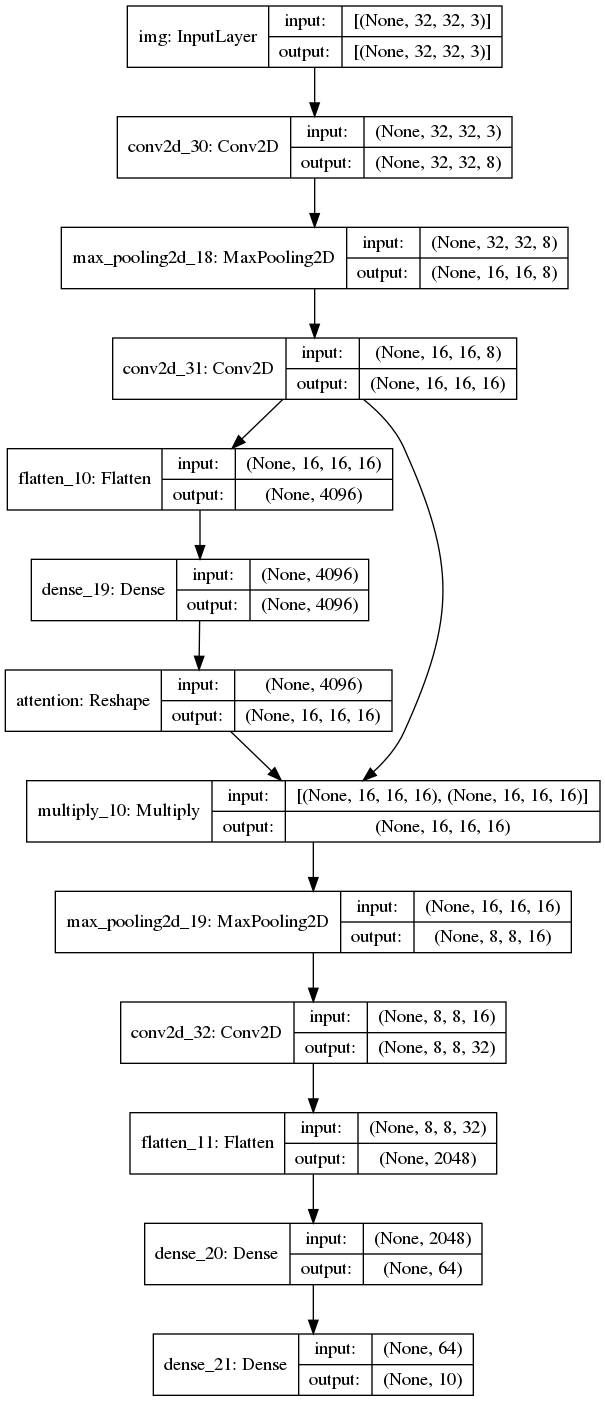

In [40]:
plot_model(model_cnn, show_shapes=True)

Those who's eyes haven't glazed over at this point will notice something different here, we're now using regular old Adam as our optimiser. For this network, with the truly massive attention layer in the middle, this is behaving better for me.

In [41]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer="Adam",
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=max_epochs*4,
                        validation_split=0.2,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience)],
                        verbose=False)

938/938 - 12s - loss: 23.6160 - accuracy: 0.7146
188/188 - 2s - loss: 23.8070 - accuracy: 0.6460


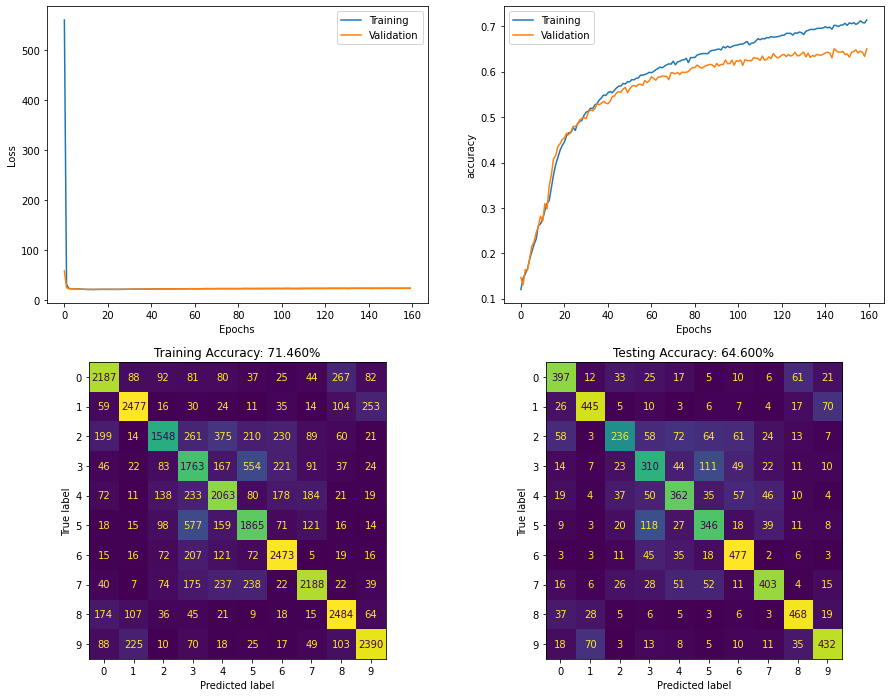

In [42]:
eval_model(model_cnn, history, x_train, y_train, x_test, y_test)

While this is perhaps not ideal from an efficiency stand point, it still works (and works fairly well) - though there's no great increase over what we had before. Nonetheless, the ability to focus on details of interest helps the model and see a good increase in performance over our baseline.

Why no pretty visuals for this one? Our attention tensor is now a 16 channel monster, so isn't so easy to visualise. While we could look at all 16-channels individually, it's not easy to make sense of, so we'll skip it.

## Final Thoughts

So what have we learnt today?

In general, attention is good, and helps our networks learn and be more selective about what information we pass through to later layers. We can view this as a dynamic filtering process, that supresses information that is uninformative and may distract the network. The area of neural attention is evolving very rapidly, and many different attention schemes have been proposed (there's probably been another paper uploaded to arXiv while you've read through this example). The ones we've looked at here are all fairly simple, and are all flavours of self-attention. 

It's important to note that there are no real "rules" as to how to craft or use attention - different things will work in different applications - and it may not always be clear why. All attention mechanisms are adding network capacity, and due to the formulation (often times we multiply the outputs of the attention sub-network with something else) the capacity increase is in fact far greater than if we just added another layer to increase the depth. With this in mind it's important to consider what attention is trying to do: location regions/features that are most useful for the task at hand, and direct the network towards these. As such, any attention mechanism needs to be able to:
* Assess the importance of a feature, either with respect to iself (self-attention) or some other layer from the network (cross-attention, not covered here)
* Threshold the importance, typically done via an activation
* Incorporate the importance into the original network representation, such that areas identified as being important are emphasised

As we've seen above, even within a very simple network there are a lot of different things we can do with respect to a simple attention mechanism (we could do more - but this example is getting very long as is). Performance changes across these, but all offer some improvement. The biggest danger with incorporating attention is setting up activations such that very little information is allowed to flow through. As long as this can be avoided, it will usually do more good than harm. 